In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "macosko_2015.h5ad"))
adata

AnnData object with n_obs × n_vars = 44808 × 24658 
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,cluster_ids,labels
r1_GGCCGCAGTCCG,2,Retinal ganglion cells
r1_CTTGTGCGGGAA,2,Retinal ganglion cells
r1_GCGCAACTGCTC,2,Retinal ganglion cells
r1_GATTGGGAGGCA,2,Retinal ganglion cells
r1_GTGCCGCCTCTC,25,Cones


In [4]:
adata.obs["labels"].value_counts()

Rods                      29400
Bipolar cells              6285
Amacrine cells             4426
Cones                      1868
Muller glia                1624
Retinal ganglion cells      432
Vascular endothelium        252
Horizontal cells            252
Fibroblasts                  85
Microglia                    67
Pericytes                    63
Astrocytes                   54
Name: labels, dtype: int64

In [5]:
colors = {
    "Amacrine cells": "#A5C93D",
    "Astrocytes": "#8B006B",
    "Bipolar cells": "#2000D7",
    "Cones": "#538CBA",
    "Fibroblasts": "#8B006B",
    "Horizontal cells": "#B33B19",
    "Microglia": "#8B006B",
    "Muller glia": "#8B006B",
    "Pericytes": "#8B006B",
    "Retinal ganglion cells": "#C38A1F",
    "Rods": "#538CBA",
    "Vascular endothelium": "#8B006B",
}

## Preprocessing

In [6]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 44808 × 17924 
    obs: 'cluster_ids', 'labels'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.19
CPU times: user 1.05 s, sys: 660 ms, total: 1.71 s
Wall time: 1.73 s


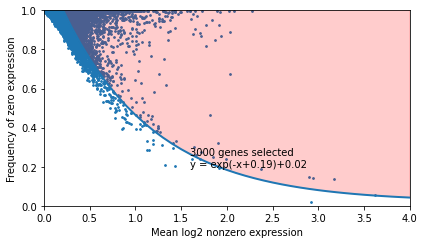

In [7]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [9]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## Utils

In [10]:
def rotate(deg):
    rad = deg * np.pi / 180
    return np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)],
    ])

## Standard t-SNE

In [11]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    learning_rate=200,
    n_iter=750,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(initialization='random', learning_rate=200, metric='cosine', n_iter=750,
     n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 12.43 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.10 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 6.8609, 50 iterations in 1.7519 sec
Iteration  100, KL divergence 6.8609, 50 iterations in 1.6232 sec
Iteration  150, KL divergence 6.5354, 50 iterations in 1.6390 sec
Iteration  200, KL divergence 5.6964, 50 iterations in 1.6520 sec
Iteration  250, KL divergence 5.4577, 50 iterations in 1.6502 sec
   --> Time elapsed: 8.32 seconds
===> Running optimization with exaggeration=1.00, lr=200.

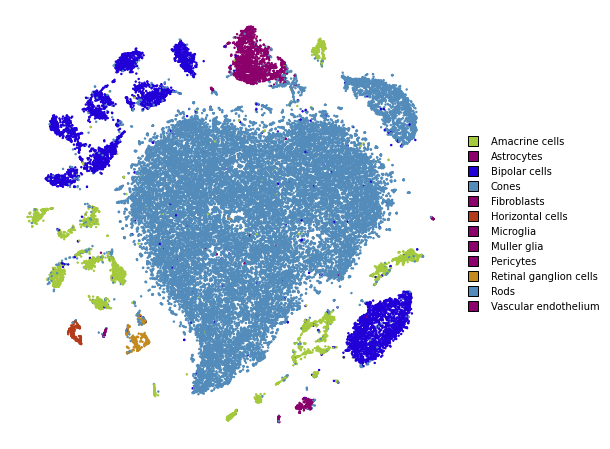

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_standard @ rotate(-130), adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax)

## Modern embedding

In [13]:
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding_modern = openTSNE.TSNE(
    affinities=affinities,
    initialization="pca",
    learning_rate="auto",
    n_iter=500,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 44.63 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 35.18 seconds
--------------------------------------------------------------------------------
TSNE(affinities=<openTSNE.affinity.Multiscale object at 0x7f2a783f5090>,
     n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=3734.00 for 250 iterations...


/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Iteration   50, KL divergence 4.4096, 50 iterations in 10.8971 sec
Iteration  100, KL divergence 3.9909, 50 iterations in 10.6663 sec
Iteration  150, KL divergence 3.9356, 50 iterations in 10.7015 sec
Iteration  200, KL divergence 3.9127, 50 iterations in 11.0403 sec
Iteration  250, KL divergence 3.9003, 50 iterations in 10.8057 sec
   --> Time elapsed: 54.11 seconds
===> Running optimization with exaggeration=1.00, lr=3734.00 for 500 iterations...
Iteration   50, KL divergence 2.4357, 50 iterations in 10.6169 sec
Iteration  100, KL divergence 2.1520, 50 iterations in 10.6075 sec
Iteration  150, KL divergence 2.0277, 50 iterations in 11.2833 sec
Iteration  200, KL divergence 1.9562, 50 iterations in 11.0412 sec
Iteration  250, KL divergence 1.9114, 50 iterations in 11.7870 sec
Iteration  300, KL divergence 1.8809, 50 iterations in 11.7661 sec
Iteration  350, KL divergence 1.8598, 50 iterations in 12.7135 sec
Iteration  400, KL divergence 1.8448, 50 iterations in 12.7348 sec
Iteration  

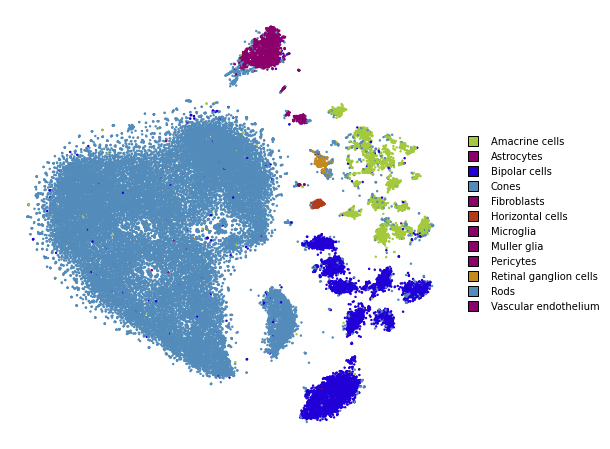

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_modern, adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax)

## Transform

### Prepare new data

In [15]:
new = anndata.read_h5ad(path.join("..", "data", "h5ad", "shekhar_2016.h5ad"))
new

AnnData object with n_obs × n_vars = 26830 × 24904 
    obs: 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [16]:
new.obs["labels"].value_counts()

rod bipolar cell              10888
type 5 cone bipolar cell       4641
Mueller cell                   2945
type 1 cone bipolar cell       1883
type 7 cone bipolar cell       1759
type 6 cone bipolar cell       1702
type 3 cone bipolar cell       1352
type 2 cone bipolar cell        558
type 4 cone bipolar cell        398
type 8/9 cone bipolar cell      313
amacrine cell                   252
retinal rod cell                 91
retinal cone cell                48
Name: labels, dtype: int64

In [17]:
new.obs["labels"] = new.obs["labels"].astype(str)
new.obs["labels"][new.obs["labels"].str.contains("bipolar cell")] = "retinal bipolar neuron"
new.obs["labels"] = new.obs["labels"].replace({
    "retinal rod cell": "Rods",
    "retinal bipolar neuron": "Bipolar cells",
    "amacrine cell": "Amacrine cells",
    "retinal cone cell": "Cones",
    "Mueller cell": "Muller glia",
    "retinal ganglion cell": "Retinal ganglion cells",
    "endothelial cell": "Vascular endothelium",
    "retina horizontal cell": "Horizontal cells",
    "fibroblast": "Fibroblasts",
    "microglial cell": "Microglia",
    "pericyte cell": "Pericytes",
    "astrocyte": "Astrocytes",
})
new.obs["labels"].value_counts()

Bipolar cells     23494
Muller glia        2945
Amacrine cells      252
Rods                 91
Cones                48
Name: labels, dtype: int64

### Align data sets

In [18]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "macosko_2015.h5ad"))
adata

AnnData object with n_obs × n_vars = 44808 × 24658 
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [19]:
adata.var_names = adata.var_names.str.upper()
new.var_names = new.var_names.str.upper()

In [20]:
new = new[:, ~new.var_names.duplicated()]

In [21]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['KITL', 'TMTC3', 'CEP290', '4930430F08RIK', '1700017N19RIK', 'MGAT4C',
       'RASSF9', 'LRRIQ1', 'ADGB', 'SLC6A15',
       ...
       'TMED6', '1700018B08RIK', 'RPRL3', 'GM23986', 'GM15656', 'TREH',
       'BC050972', 'GM23791', 'GM15023', 'VSIG1'],
      dtype='object', length=20808)

In [22]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [23]:
adata.shape, new.shape

((44808, 20808), (26830, 20808))

In [24]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

In [25]:
adata

AnnData object with n_obs × n_vars = 44808 × 20808 
    obs: 'cluster_ids', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.36
CPU times: user 1.05 s, sys: 600 ms, total: 1.65 s
Wall time: 1.65 s


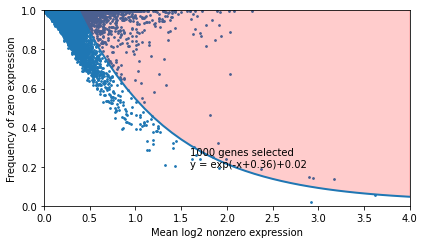

In [26]:
%time gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [27]:
adata_1000 = adata[:, gene_mask]
new_1000 = new[:, gene_mask]

### Find embeddings for new data

In [28]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    adata_1000.X.toarray(),
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 33.69 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.10 seconds
CPU times: user 2min 8s, sys: 3.06 s, total: 2min 11s
Wall time: 34.9 s


In [29]:
embedding = openTSNE.TSNEEmbedding(
    embedding_modern.view(np.ndarray),
    affinities,
    n_jobs=8,
    verbose=True,
)

In [30]:
%time new_embedding = embedding.transform(new_1000.X.toarray(), learning_rate=1, n_iter=500)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 16.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.12 seconds
===> Running optimization with exaggeration=4.00, lr=1.00 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=1.00 for 500 iterations...
Iteration   50, KL divergence 581561.7837, 50 iterations in 0.7055 sec
Iteration  100, KL divergence 581591.5582, 50 iterations in 0.7230 sec
Iteration  150, KL divergence 581550.2306, 50 iterations in 0.6403 sec
Iteration  200, KL divergence 581549.9606, 50 iterations in 0.6643 sec
Iteration  250, KL divergence 581548.1752, 50 iterations in 0.6192 sec
Iteration  300, KL divergence 581569.1629, 50 iterations in 0.7385 sec
Iteration  350, KL divergence 581571.5982, 50 iterations in 0.7026 sec
Iteration  400, KL divergence 581555.9847, 50 iterations in 0.7094 sec
Iteration  450, KL divergence 581564.3565, 50

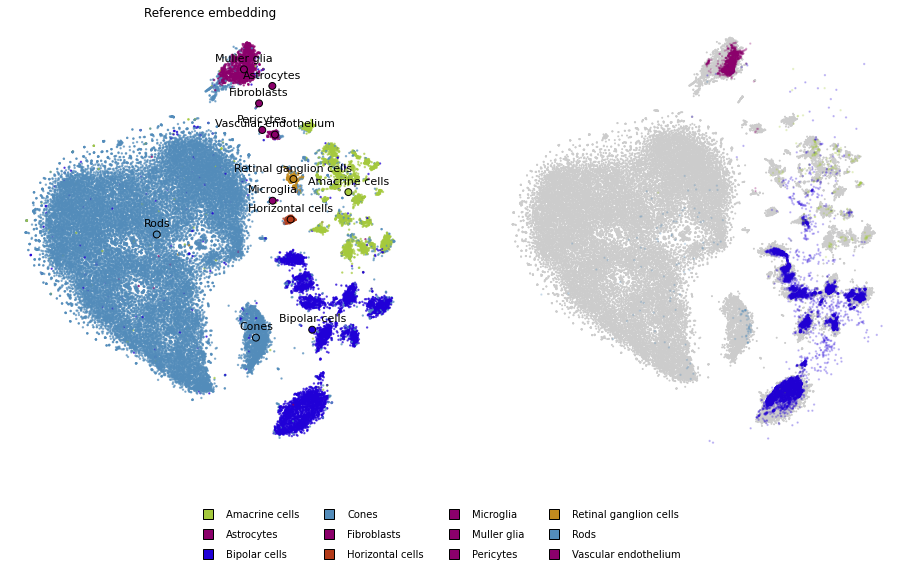

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

utils.plot(
    embedding, adata.obs["labels"], ax=ax[0], title="Reference embedding", s=2, colors=colors,
    draw_centers=True, draw_cluster_labels=True, fontsize=11,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(embedding, np.ones_like(adata.obs_names), ax=ax[1],
           colors=colors_bw, alpha=1, s=1, draw_legend=False)
utils.plot(new_embedding, new.obs["labels"], ax=ax[1],
           draw_legend=False, s=2, alpha=0.2, colors=colors)
#ax[1].set_title("Transformed samples")

for ax_ in ax.ravel(): ax_.axis("equal")

## Final figure

In [32]:
pd.DataFrame(embedding_standard, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("macosko/standard.csv")
pd.DataFrame(embedding_modern, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("macosko/modern.csv")
pd.DataFrame(new_embedding, columns=["tSNE-1", "tSNE-2"], index=new.obs_names).to_csv("macosko/transform_shekhar.csv")

In [33]:
cluster_ids = np.array(adata.obs["cluster_ids"], dtype=float).astype(int)
np.unique(cluster_ids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

In [34]:
cluster_cell_mapping = {
    1: "Horizontal cells",
    2: "Retinal ganglion cells",
    24: "Rods",
    25: "Cones",
    34: "Muller glia",
    35: "Astrocytes",
    36: "Fibroblasts",
    37: "Vascular endothelium",
    38: "Pericytes",
    39: "Microglia",
}
for i in range(3, 24):
    cluster_cell_mapping[i] = "Amacrine cells"
for i in range(26, 34):
    cluster_cell_mapping[i] = "Bipolar cells"

In [35]:
cluster_ids_ = [cluster_cell_mapping[yi] if yi in (1, 2, 24, 25, 34, 35, 36, 37, 38, 39) else yi 
                for yi in cluster_ids]
cluster_ids_ = np.array(cluster_ids_)
np.unique(cluster_ids_)

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '26', '27', '28', '29', '3', '30', '31', '32',
       '33', '4', '5', '6', '7', '8', '9', 'Astrocytes', 'Cones',
       'Fibroblasts', 'Horizontal cells', 'Microglia', 'Muller glia',
       'Pericytes', 'Retinal ganglion cells', 'Rods',
       'Vascular endothelium'], dtype='<U22')

In [36]:
colors_ = {}
for label in np.unique(cluster_ids_):
    try:
        assert int(label) in cluster_cell_mapping
        colors_[label] = colors[cluster_cell_mapping[int(label)]]
    except ValueError:
        colors_[label] = colors[label]
        
np.array(list(colors_.keys()))

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '26', '27', '28', '29', '3', '30', '31', '32',
       '33', '4', '5', '6', '7', '8', '9', 'Astrocytes', 'Cones',
       'Fibroblasts', 'Horizontal cells', 'Microglia', 'Muller glia',
       'Pericytes', 'Retinal ganglion cells', 'Rods',
       'Vascular endothelium'], dtype='<U22')

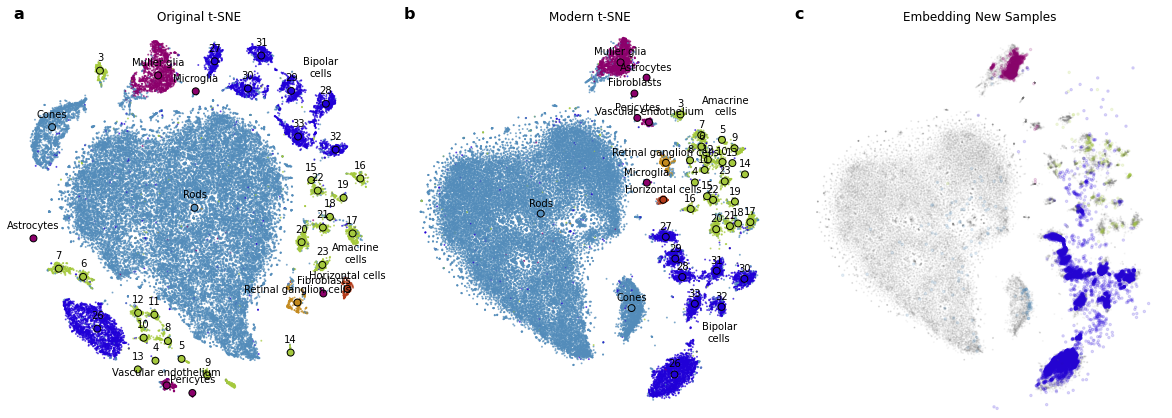

In [69]:
import string

fig, ax = plt.subplots(ncols=3, figsize=(16, 16 / 3))

utils.plot(embedding_standard @ rotate(-120) * [-1, 1], cluster_ids_, colors=colors_, ax=ax[0], fontsize=10,
           draw_centers=True, draw_cluster_labels=True, draw_legend=False)
ax[0].set_title("Original t-SNE")

utils.plot(embedding_modern, cluster_ids_, colors=colors_, ax=ax[1], fontsize=10,
           draw_centers=True, draw_cluster_labels=True, draw_legend=False)
ax[1].set_title("Modern t-SNE")

colors_bw = {1: "#666666"}
utils.plot(embedding_modern, np.ones_like(adata.obs["labels"]), colors=colors_bw, ax=ax[2],
           draw_centers=False, draw_legend=False, alpha=0.05)
utils.plot(new_embedding, new.obs["labels"], colors=colors, ax=ax[2],
           draw_centers=False, draw_legend=False, alpha=0.15, s=6, lw=0)
ax[2].set_title("Embedding New Samples")

for ax_ in ax.ravel(): ax_.axis("equal")
    
ax[2].set_xlim(ax[1].get_xlim()), ax[2].set_ylim(ax[1].get_ylim())

plt.text(38, -12.5, "Amacrine\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[0].transData)
plt.text(30, 30, "Bipolar\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[0].transData)

plt.text(42, 32, "Amacrine\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[1].transData)
plt.text(40, -38, "Bipolar\ncells", color="k", fontsize=10, horizontalalignment="center", transform=ax[1].transData)

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase):
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

plt.savefig(path.join("..", "figures", "macosko2015.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=16 / 3)